# TUTORIAL: 
# Data assimilation using real experimental data

We can now put everything we have learned together. 

We can investigate two scenarios:

A) Assume that we have access to the post-processed data and assimilate it. This situation simplifies the problem as the experimental data is not biased (see tutorial TA_azimuthal_data to see how the raw data is biased).
-   Truth: post-processed data 
-   Observations: post-processed data + noise (possibly coloured noise)

B) Assume a realistic setting in which the post-processed data is not available on the fly to input to the data assimilation algorithm. Here, we need to address the issue of biased observations.
-   Truth: post-processed data
-   Observations: raw data

In this tutorial we will work with option A. For option B go to the tutorial ```11_DA_annular_raw.ipynb```.

In [3]:
import numpy as np
import os
import matplotlib.pyplot as plt
from essentials.physical_models import Annular
from essentials.bias_models import ESN
import scipy.io as sio

rng = np.random.default_rng(0)


if os.path.isdir('/mscott/'):
    data_folder = '/mscott/an553/data/'  # set working directory to 
else:
    data_folder = "../data/"

## 1. Load data 
Create the reference truth and the observations.

*The code below can be compacted with the function ```create_truth```, which outputs a dictionary:*
```
  
from essentials.create import create_truth
truth = create_truth(filename, t_start, t_stop, Nt_obs, std_obs, noise_type='gauss', post_processed=True)
```

In [20]:
ER = 0.5625
filename = data_folder + 'annular/ER_{}'.format(ER)

# Load experimental data
mat = sio.loadmat(filename + '.mat')
y_true, t_true = [mat[key].squeeze() for key in ['y_filtered', 't']]
Nt, Nq = y_true.shape
dt_t = t_true[1] - t_true[0]

# Add noise to the truth to "create" the observations
std_obs = 0.1
noise = rng.multivariate_normal(np.zeros(Nq), np.eye(Nq) * std_obs ** 2, Nt)
y_raw = y_true + noise * y_true

# Select the observations time-window
t_start = 2* Annular.t_transient + 1.
t_stop = t_start + Annular.t_CR * 2
Nt_obs = 15

# Sample the observations
obs_idx = np.arange(t_start // dt_t, t_stop // dt_t + 1, Nt_obs, dtype=int)
y_obs, t_obs = [xx[obs_idx] for xx in [y_raw, t_true]]


## 2. Define the forecast model
This is the physical model which we will use to model the true data.
Here, we select the filter parameters and create ensemble

*The code below can be compacted as*
```
from essentials.create import create_ensemble
ensemble = create_ensemble(model=Annular, **filter_params)
```

In [208]:
alpha0 = dict(nu=(40., 50.),
              c2beta=(5, 20),
              kappa=(1.E-4, 1.3E-4),
              epsilon=(0.0001, 0.03),
              omega=(1090 * 2 * np.pi, 1100 * 2 * np.pi),
              theta_b=(0.5, 0.7),
              theta_e=(0.5, 0.8)
              )

alpha0_mean = dict()
for alpha, lims in alpha0.items():
    alpha0_mean[alpha] = 0.5 * (lims[0] + lims[1])

ensemble = Annular(**alpha0_mean)

filter_params = {'m': 10, 
                 'inflation': 1.01,
                 'std_psi': 0.3,
                 'std_a': alpha0}

# Forecast model to initialise the ensemble after transient
state, t_ = ensemble.time_integrate(int(ensemble.t_CR / ensemble.dt))
ensemble.update_history(state[-1], reset=True)

ensemble.init_ensemble(**filter_params)

ensemble_no_bias = ensemble.copy()



Visualize ensemble initialization

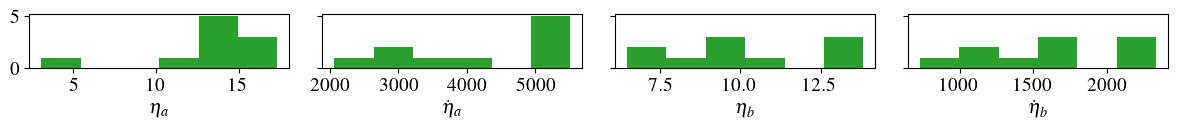

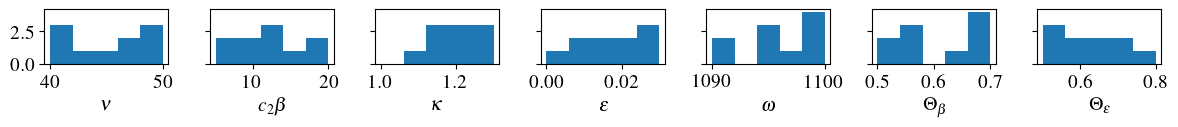

In [207]:
from essentials.plotResults import plot_ensemble
plot_ensemble(ensemble, reference_params={'kappa': 1e-4, 'omega': 2 * np.pi})

## 4. Train an ESN to model the model bias
The procedure is the following

&emsp; i. Initialise ESN Bias class object
&emsp; ii. Create synthetic bias to use as training data 
&emsp; iii. Train the ESN
&emsp; iv. Create washout data

<br><br>
**4.1. Initialise the ESN**

In [7]:
from essentials.create import create_bias_training_dataset


train_params = dict(model=ESN, 
                    upsample=5,
                    N_units=50,
                    N_wash=3,
                    t_train=ensemble.t_CR * 10,
                    # Training data generation options
                    augment_data=True,
                    L=10,
                    noise=0.1, 
                    # Hyperparameter search ranges
                    rho_range=(0.5, 1.1),
                    sigma_in_range=(np.log10(1e-5), np.log10(1e1)),
                    tikh_range=[1e-16]
                    )
ensemble.init_bias(**train_params)



**4.2. Create training data**

The details of the code inside ```create_bias_training_dataset()``` function is explained in the tutorial ```Class_Bias.ipynb```.

In [8]:
train_data = create_bias_training_dataset(y_raw, y_true, ensemble, **train_params)


**4.3. Train the ESN**

The training convergence, hyperparameter optimization and testing results are saved in a pdf file in *figs_ESN* folder.

In [9]:
ensemble.bias.train_bias_model(**train_data)


 ----------------- HYPERPARAMETER SEARCH ------------------
 4x4 grid and 4 points with Bayesian Optimization
		 rho	 sigma_in	 tikh	 MSE val 
1	 5.000e-01	 1.000e-05	 1.000e-16	 -2.0181
2	 5.000e-01	 1.000e-03	 1.000e-16	 1.6285
3	 5.000e-01	 1.000e-01	 1.000e-16	 20.2072
4	 5.000e-01	 1.000e+01	 1.000e-16	 -3.6089
5	 7.000e-01	 1.000e-05	 1.000e-16	 -3.1836
6	 7.000e-01	 1.000e-03	 1.000e-16	 0.1759
7	 7.000e-01	 1.000e-01	 1.000e-16	 -3.3996
8	 7.000e-01	 1.000e+01	 1.000e-16	 -3.0395
9	 9.000e-01	 1.000e-05	 1.000e-16	 -3.0132
10	 9.000e-01	 1.000e-03	 1.000e-16	 -2.8342
11	 9.000e-01	 1.000e-01	 1.000e-16	 -4.0545
12	 9.000e-01	 1.000e+01	 1.000e-16	 -2.8965
13	 1.100e+00	 1.000e-05	 1.000e-16	 -3.3891
14	 1.100e+00	 1.000e-03	 1.000e-16	 1.5975
15	 1.100e+00	 1.000e-01	 1.000e-16	 -2.8781
16	 1.100e+00	 1.000e+01	 1.000e-16	 -2.9821
17	 9.000e-01	 3.467e-01	 1.000e-16	 -4.0418
18	 9.224e-01	 1.951e-01	 1.000e-16	 -4.1793
19	 7.750e-01	 1.865e-01	 1.000e-16	 -4.0660
20	 7.437e-01

**4.4. Create washout data**

We retrieve from the raw data a ```N_wash``` number of observations to use for initialising the ESN, i.e., to perform the washout. 
The ESN initialization must be before the fist observation.

In [49]:
ensemble.bias.t_init = t_obs[0] - 2 * Nt_obs * dt_t

i1 = np.argmin(abs(ensemble.bias.t_init - t_true))
i0 = i1 - ensemble.bias.N_wash  * ensemble.bias.upsample 

wash_obs = y_raw[i0:i1 + 1:ensemble.bias.upsample]
wash_t = t_true[i0:i1 + 1:ensemble.bias.upsample]

## 5. Apply data assimilation
We now have all the ingredients to start our data assimilation algorithm.

In [50]:
ensemble_ESN = ensemble.copy()


In [124]:
from essentials.DA import dataAssimilation


# from essentials.create import create_truth
# truth['wash_obs'] = wash_obs
# truth['wash_t'] = wash_t
# y_obs, t_obs = [truth[key] for key in ['y_obs', 't_obs']]

DA_kwargs = dict(y_obs=y_obs, t_obs=t_obs, std_obs=std_obs, wash_obs=wash_obs, wash_t=wash_t)

ensemble_ESN.filter = 'rBA_EnKF'
ensemble_ESN.regularization_factor = 5.
ensemble_no_bias.filter ='EnSRKF'


out = []
for ens in [ensemble_no_bias, ensemble_ESN]:
# for ens in [ensemble_ESN]:
    ens = ens.copy()
    ens.t_init = t_obs[0]
    
    filter_ens = dataAssimilation(ens, **DA_kwargs.copy())
    
    #Forecast the ensemble further without assimilation
    Nt_extra = int(filter_ens.t_CR / filter_ens.dt) * 5
    
    psi, t = filter_ens.time_integrate(Nt_extra)
    filter_ens.update_history(psi, t)
    
    y = filter_ens.get_observable_hist(Nt_extra)
    b, t_b = filter_ens.bias.time_integrate(t=t, y=y)
    filter_ens.bias.update_history(b, t_b)
    
    out.append(filter_ens)
    # out[-1] = filter_ens



 ------------------ Annular Model Parameters ------------------ 
	 ER = 0.5
	 Nq = 4
	 c2beta = 12.5
	 dt = 1.95313e-05
	 epsilon = 0.01505
	 kappa = 0.000115
	 n = 1.0
	 nu = 45.0
	 omega = 6880.09
	 theta_b = 0.6
	 theta_e = 0.65

 ----------------  Bias model parameters ----------------  
 Bias model: NoBias

 -------------------- ASSIMILATION PARAMETERS -------------------- 
 	 Filter = EnSRKF  
	 bias = NoBias 
 	 m = 10 
 	 Time steps between analysis = None 
 	 Inferred params = ['nu', 'c2beta', 'kappa', 'epsilon', 'omega', 'theta_b', 'theta_e'] 
 	 Inflation = 1.01 
 	 Ensemble std(psi0) = 0.3
 	 Ensemble std(alpha0) = {'nu': (40.0, 50.0), 'c2beta': (5, 20), 'kappa': (0.0001, 0.00013), 'epsilon': (0.0001, 0.03), 'omega': (6848.671984825749, 6911.503837897545), 'theta_b': (0.5, 0.7), 'theta_e': (0.5, 0.8)}
 	 Number of analysis steps = 38, t0=1.99998046875, t1=2.0194921875
 --------------------------------------------
Elapsed time to first observation: 5.327183246612549 s
Assim

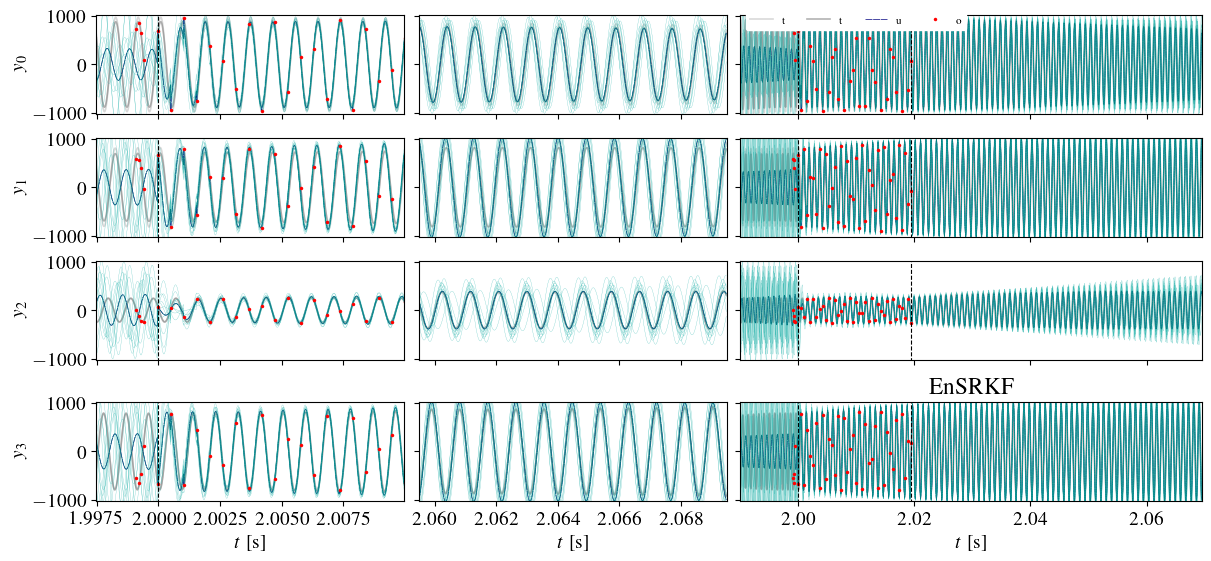

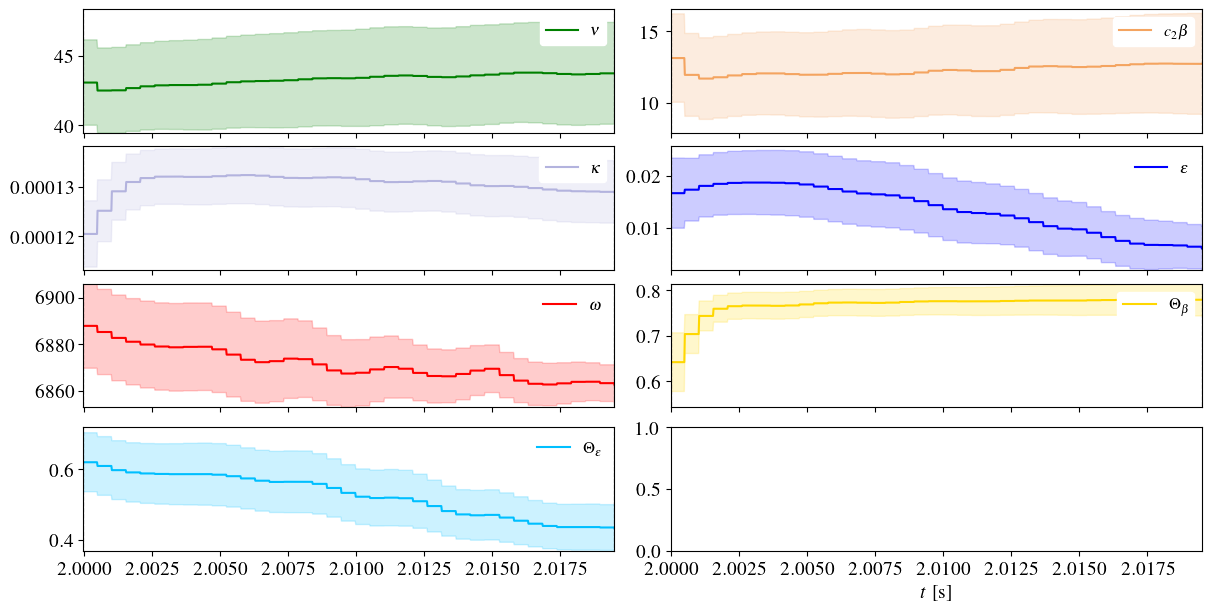

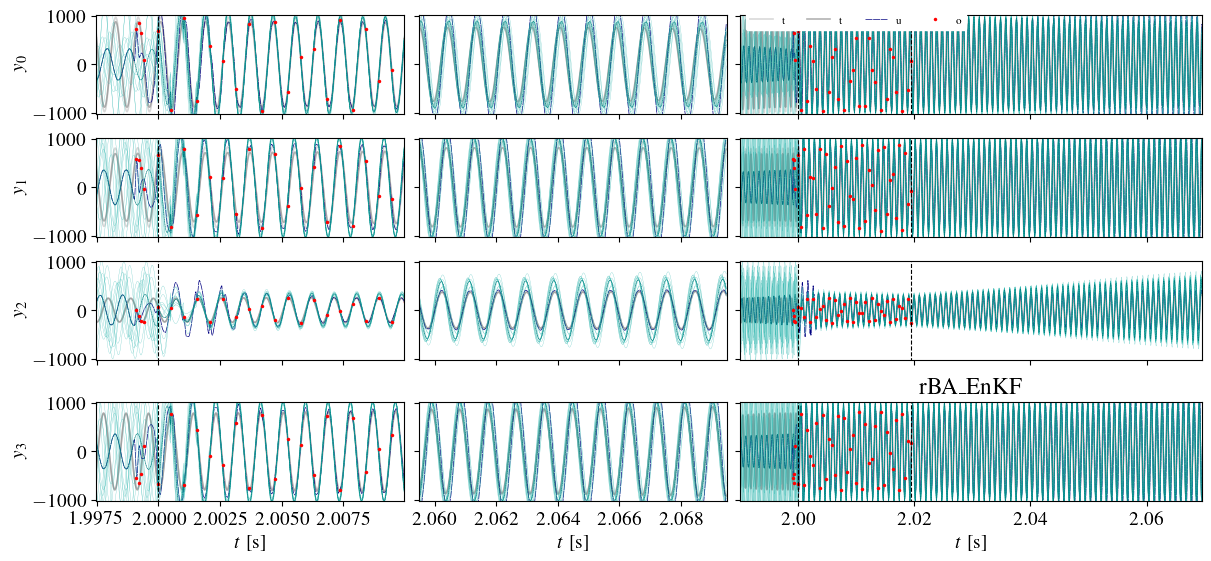

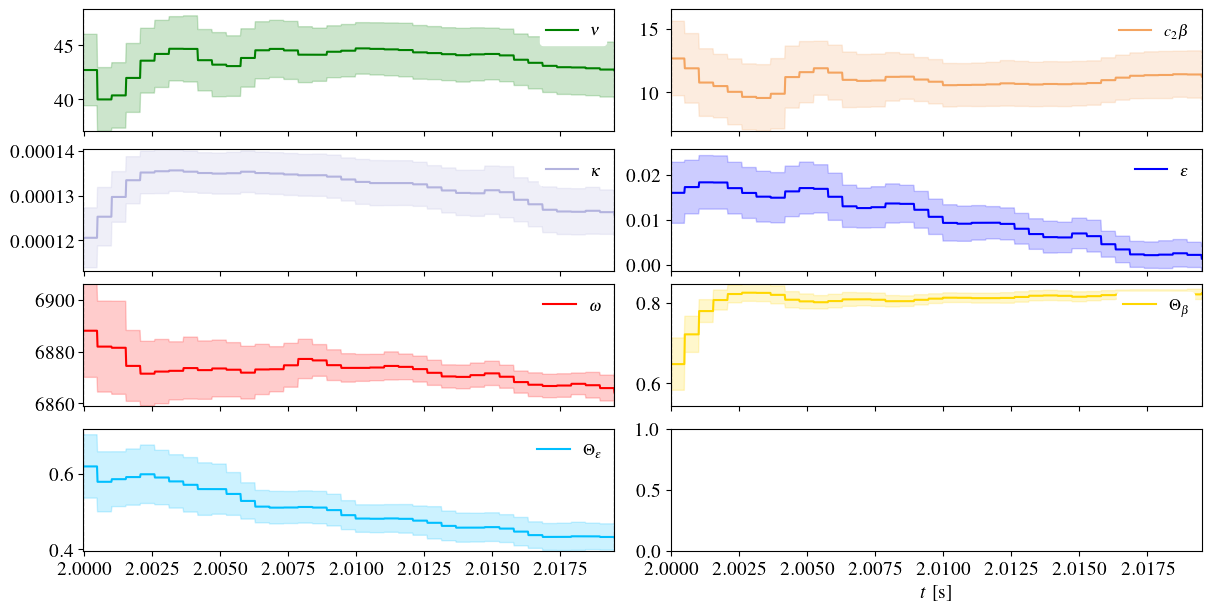

In [192]:
# from essentials.plotResults import plot_timeseries, plot_parameters


truth = dict(y_raw=y_raw, y_true=y_true, t=t_true, dt=dt_t,
             t_obs=t_obs, y_obs=y_obs, dt_obs=Nt_obs * dt_t,
             std_obs=std_obs, wash_t=wash_t, wash_obs=wash_obs)

for filter_ens in out:
    plot_timeseries(filter_ens, truth)
    plt.title(filter_ens.filter)
    plot_parameters(filter_ens, truth)

In [1]:
 # Plot RMS error
from essentials.Util import interpolate

fig, axs_all = plt.subplots(nrows=2, ncols=2, sharex=True, sharey='row', figsize=(15, 5), layout='tight')


i0 = np.argmin(abs(truth['t'] - truth['t_obs'][0] + ensemble.t_CR))
i1 = np.argmin(abs(truth['t'] - filter_ens.hist_t[-1]))

t_ref, y_ref = [truth[key][i0:i1] for key in ['t', 'y_raw']]
y_ref = np.expand_dims(y_ref, axis=-1)

for filter_ens, axs in zip(out, axs_all.T):
    
    
    y_est = filter_ens.get_observable_hist()
    # y_est = np.mean(y_est, -1)
    # 
    # y_est = interpolate(filter_ens.hist_t, y_est, filter_ens.bias.hist_t)
    # # y_est += filter_ens.bias.hist.squeeze()
    # 
    y_est = interpolate(filter_ens.hist_t, y_est, t_ref)
    
    
    # root-mean square error
    R = np.sqrt(np.sum((y_ref - y_est) ** 2, axis=1))
    
    
    
    ax = axs[0]
    ax.plot(t_ref, R, '.', c='tab:red', ms=.3)
    ax.axvline(truth['t_obs'][0], c='k', ls='--', alpha=0.5)
    ax.axvline(truth['t_obs'][-1], c='k', ls='--', alpha=0.5)
    ax.set(title=filter_ens.filter, xlim=[t_ref[0], t_ref[-1]], ylim=[0, None])
    
    iend = np.argmin(abs(t_ref - t_obs[-1]))
    mean_RMS = np.mean(R[iend:])
    ax.axhline(mean_RMS, xmin=(t_obs[-1]-t_ref[0])/(t_ref[-1]-t_ref[0]))
    print(mean_RMS, np.max(R[iend:]), np.median(R[iend:]))
    
    
    ax = axs[1]
    ax.plot(t_ref, y_ref[:, 0], lw=1.5, c='gray', alpha=0.7)
    ax.plot(t_ref, np.mean(y_est[:, 0], -1), '-', lw=.4, c='royalblue')
    
    
    


NameError: name 'plt' is not defined

In [210]:
# TODO: Plot PDF of RMS
# TODO: Plot ensemble spread
# TODO: Plot timeseries PDF and PSD

In [222]:
(t_obs[-1]-t_ref[0])/(t_ref[-1]-t_ref[0])

0.3712530712530722